Checking the rater agreement (pct viewing time) for all frames

In [140]:
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.misc

Load the ratings of the algorithm and the raters

In [141]:
# Load data from algorithmic tracking
raterFiles = glob.glob("data/P*.txt")
df_algoFiles = (pd.read_csv(f, header = None) for f in raterFiles)
df_algo   = pd.concat(df_algoFiles, ignore_index=True, axis = 0)

# Load data from manual ratings
raterFiles = glob.glob("data/data_Rater*.csv")
df_raterFiles = (pd.read_csv(f, header = 0) for f in raterFiles)
df_rater   = pd.concat(df_raterFiles, ignore_index=True)

Prepare the data to get it into long format

In [142]:
# Only take the last judgement of each rater
df_rater.drop_duplicates(subset=['Rater', 'Frame', 'Trial'], keep='last', inplace = True)

# Rename columns
df_algo.columns = ["Trial", "Label", "1", "2", "3", "4", "5", "6", "VisiblePoints", "7", "8" ]

# Add frame number column
df_algo["Frame"] = df_algo.groupby(['Trial']).cumcount()

# Add column for rater
df_algo['Rater'] = 'Algorithm'

# Set datatypes
df_algo["Trial"] = df_algo["Trial"].astype("string")
df_algo["Frame"] = df_algo["Frame"].astype("string")
df_algo["Label"] = df_algo["Label"].astype("string")
df_rater["Frame"] = df_rater["Frame"].astype("string")
df_rater["Trial"] = df_rater["Trial"].astype("string")
df_rater["Label"] = df_rater["Label"].astype("string")

# Rename the labels to match the AOI from the algorithmic approach
df_algo['Label'] = df_algo['Label'].str.replace("Nose","Head")
df_algo['Label'] = df_algo['Label'].str.replace("Neck","Chest")
df_algo['Label'] = df_algo['Label'].str.replace("LElbow","Left arm")
df_algo['Label'] = df_algo['Label'].str.replace("RElbow","Right arm")
df_algo['Label'] = df_algo['Label'].str.replace("RKnee","Right leg")
df_algo['Label'] = df_algo['Label'].str.replace("LKnee","Left leg")
df_algo['Label'] = df_algo['Label'].str.replace("MidHip","Pelvis")

# Check the unique values
# df_algo['Label'].unique()

Merge the data into Long format

In [143]:
# Merge data frames
df = pd.concat([df_algo, df_rater], join='outer', keys=['Trial', 'Frame', 'Rater', 'Label']).reset_index(drop=True)

# only keep rows where all ratings are available
def filterRows(group):
    if group.shape[0] > 1:
        return group

df = df.groupby(['Trial', 'Frame']).apply(filterRows).reset_index(drop=True)

df.ffill(inplace=True)
df = df[['Trial', 'Label', 'VisiblePoints', 'Frame', 'Rater']]

df.drop(columns=['VisiblePoints'], inplace=True)
df.to_csv("results/DataLong.csv", index=False)

What happens when gaze is on "Other"


In [157]:
# Groupby mode

def mode_of_frame(group):
    group['Mode'] = group.Label.mode()[0]
    group['isAnyOther'] = (group.Label == "Other").any()
    group['Algorithm_Label'] = group.loc[group.Rater == "Algorithm", 'Label']
    return group

df = df.groupby(['Trial', 'Frame']).apply(mode_of_frame)

       Trial  Label Frame      Rater   Mode  AnyOther  isAnyOther  \
0     P01T04   Head   175  Algorithm   Head     False       False   
1     P01T04   Head   175     Rater2   Head     False       False   
2     P01T04   Head   175     Rater1   Head     False       False   
3     P01T04   Head   175     Rater3   Head     False       False   
4     P01T04  Chest   176  Algorithm  Chest     False       False   
...      ...    ...   ...        ...    ...       ...         ...   
5965  P07T23  Chest   423     Rater1  Chest     False       False   
5966  P07T23  Chest   423     Rater3  Chest     False       False   
5967  P07T23  Chest   424     Rater2  Chest     False       False   
5968  P07T23  Chest   424     Rater1  Chest     False       False   
5969  P07T23  Chest   424     Rater3  Chest     False       False   

     Algorithm_Label  
0               Head  
1               <NA>  
2               <NA>  
3               <NA>  
4              Chest  
...              ...  
5965      

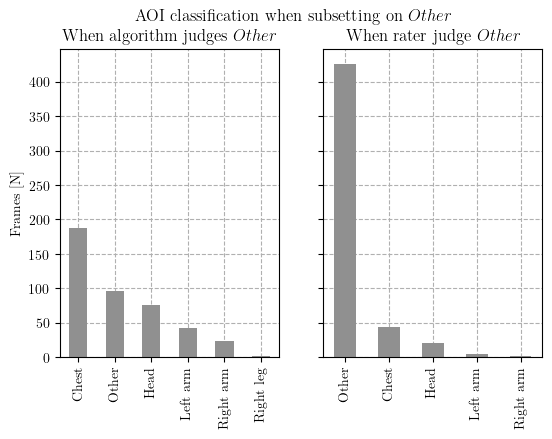

In [168]:
# Other plot

%matplotlib inline
mpl.style.use('default')

# The data
pct_algorithm = df.loc[(df.Rater == "Algorithm") & (df.Label == "Other"), 'Mode'].value_counts() 
pct_rater1 = df.loc[df.isAnyOther == 1, 'Algorithm_Label'].value_counts()

# Plot settings
# Requires probably on linux: sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
mpl.rcParams.update(
    {
        'font.family': 'serif',
        'text.usetex': True,
    }
)

# Figure settings for export
pts_document_with = 450. # How wide is the page
pts_per_inch = 1. / 72.27
figure_width = pts_document_with * pts_per_inch

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (figure_width,4), sharey = True)

axes[0].set_axisbelow(True)
axes[1].set_axisbelow(True)

pct_algorithm.plot(kind = 'bar', ax = axes[0], color = '#909090')
pct_rater1.plot(kind = 'bar', ax = axes[1], color = '#909090')

axes[0].grid(linestyle='dashed')
axes[1].grid(linestyle='dashed')

fig.suptitle("AOI classification when subsetting on $Other$")
axes[0].set_ylabel("Frames [N]")
axes[0].set_title("When algorithm judges $Other$")
axes[1].set_title("When rater judge $Other$")

# Save
plt.savefig("RaterOtherSubset.svg", bbox_inches='tight')




Calculate the agreement betweeen each rater and the algorithm

In [169]:
# Create rating agreements between raters and algorithm, and among raters. Need data in wide format for this
df = df.pivot(index=['Trial', 'Frame'], columns='Rater', values='Label')

# Columns with comparison values
df['Rater1_Algorithm'] = df.Rater1 == df.Algorithm
df['Rater2_Algorithm'] = df.Rater2 == df.Algorithm
df['Rater3_Algorithm'] = df.Rater3 == df.Algorithm

# DROP NAs
df.dropna(inplace=True)

# Calculate the rating agreement
rater1_algorithm = ((df.Rater1_Algorithm.astype(int).sum() / df.shape[0]) * 100)
rater2_algorithm = ((df.Rater2_Algorithm.astype(int).sum() / df.shape[0]) * 100)
rater3_algorithm = ((df.Rater3_Algorithm.astype(int).sum() / df.shape[0]) * 100)

# Back to long format
df = df.stack().rename('Label').reset_index(['Frame', 'Trial', 'Rater'])

In [170]:
df.to_csv("data_all.csv")

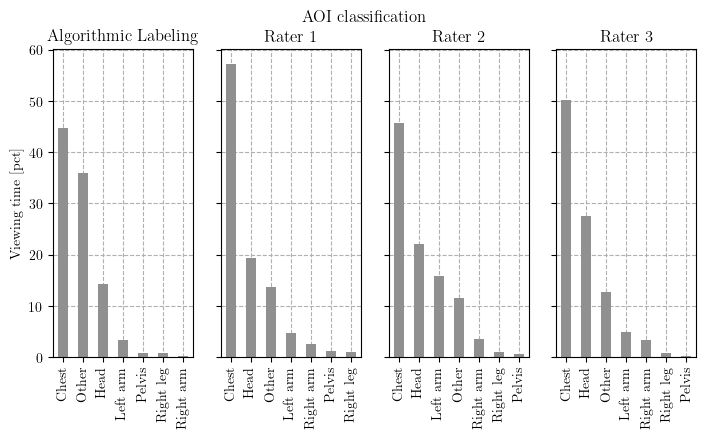

In [174]:
%matplotlib inline
mpl.style.use('default')

# The data
pct_algorithm = (df.loc[df.Rater == "Algorithm", 'Label'].value_counts() / df.loc[df.Rater == "Algorithm"].shape[0]) * 100
pct_rater1 = (df.loc[df.Rater == "Rater1", 'Label'].value_counts() / df.loc[df.Rater == "Rater1"].shape[0]) * 100
pct_rater2 = (df.loc[df.Rater == "Rater2", 'Label'].value_counts() / df.loc[df.Rater == "Rater2"].shape[0]) * 100
pct_rater3 = (df.loc[df.Rater == "Rater3", 'Label'].value_counts() / df.loc[df.Rater == "Rater3"].shape[0]) * 100

# Plot settings
# Requires probably on linux: sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
mpl.rcParams.update(
    {
        'font.family': 'serif',
        'text.usetex': True,
    }
)

# Figure settings for export
pts_document_with = 600. # How wide is the page
pts_per_inch = 1. / 72.27
figure_width = pts_document_with * pts_per_inch

# Plot
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (figure_width,4), sharey = True)

axes[0].set_axisbelow(True)
axes[1].set_axisbelow(True)
axes[2].set_axisbelow(True)
axes[3].set_axisbelow(True)

pct_algorithm.plot(kind = 'bar', ax = axes[0], color = '#909090')
pct_rater1.plot(kind = 'bar', ax = axes[1], color = '#909090')
pct_rater2.plot(kind = 'bar', ax = axes[2], color = '#909090')
pct_rater3.plot(kind = 'bar', ax = axes[3], color = '#909090')

axes[0].grid(linestyle='dashed')
axes[1].grid(linestyle='dashed')
axes[2].grid(linestyle='dashed')
axes[3].grid(linestyle='dashed')

fig.suptitle("AOI classification")
axes[0].set_ylabel("Viewing time [pct]")
axes[0].set_title("Algorithmic Labeling")
axes[1].set_title("Rater 1")
axes[2].set_title("Rater 2")
axes[3].set_title("Rater 3")

# Save
plt.savefig("RaterComparison.svg", bbox_inches='tight')